<a href="https://colab.research.google.com/github/BerhanDemiralp/Coupon-Recommendation/blob/main/coupon_recommendation_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Attribute Information:

**destination:** No Urgent Place, Home, Work

**passanger:** Alone, Friend(s), Kid(s), Partner (who are the passengers in the car)

**weather:** Sunny, Rainy, Snowy

**temperature:** 55, 80, 30

**time:** 2PM, 10AM, 6PM, 7AM, 10PM

**coupon:** Restaurant (<20dollars), Coffee House, Carry out & Take away, Bar, Restaurant(20-50 dollars)

**expiration:** 1d, 2h (the coupon expires in 1 day or in 2 hours)

**gender:** Female, Male

**age:** 21, 46, 26, 31, 41, 50plus, 36, below21

**maritalStatus:** Unmarried partner, Single, Married partner, Divorced, Widowed


**has_Children:** 1, 0

**education:** Some college - no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School

**occupation:** Unemployed, Architecture & Engineering, Student,Education&Training&Library, Healthcare Support,Healthcare Practitioners & Technical, Sales & Related, Management,Arts Design Entertainment Sports & Media, Computer & Mathematical,Life Physical Social Science, Personal Care & Service,Community & Social Services, Office & Administrative Support,Construction & Extraction, Legal, Retired,Installation Maintenance & Repair, Transportation & Material Moving,Business & Financial, Protective Service,Food Preparation & Serving Related, Production Occupations,Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry
income: 37500 - 49999, 62500 - 74999, 12500 - 24999, 75000 - 87499,50000 - 62499, 25000 - 37499, 100000 or More, 87500 - 99999, Less than 12500（unit：dollar）

**Bar:** never, less1, 1-3, gt8, nan4-8 (feature meaning: how many times do you go to a bar every month?)

**CoffeeHouse:** never, less1, 4-8, 1-3, gt8, nan (feature meaning: how many times do you go to a coffeehouse every month?)

**CarryAway:** n4-8, 1-3, gt8, less1, never (feature meaning: how many times do you get take-away food every month?)
RestaurantLessThan20: 4-8, 1-3, less1, gt8, never (feature meaning: how many times do you go to a restaurant with an average expense per person of less than 20 dollars every month?)

**Restaurant20To50:** 1-3, less1, never, gt8, 4-8, nan (feature meaning: how many times do you go to a restaurant with average expense per person of 20 - 50 dollars every month?)

**toCoupon_GEQ15min:** 0,1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 15 minutes)

**toCoupon_GEQ25min:** 0, 1 (feature meaning: driving distance to the restaurant/bar for using the coupon is greater than 25 minutes)

**direction_same:** 0, 1 (feature meaning: whether the restaurant/bar is in the same direction as your current destination)

**direction_opp:** 1, 0 (feature meaning: whether the restaurant/bar is in the same direction as your current destination)

**Y:** 1, 0 (whether the coupon is accepted)

## Imports

In [27]:
pip install ucimlrepo

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    roc_auc_score,
    average_precision_score,
    f1_score
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True


In [29]:
from ucimlrepo import fetch_ucirepo
in_vehicle_coupon_recommendation = fetch_ucirepo(id=603)
print(in_vehicle_coupon_recommendation.metadata)
print(in_vehicle_coupon_recommendation.variables)


{'uci_id': 603, 'name': 'In-Vehicle Coupon Recommendation', 'repository_url': 'https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation', 'data_url': 'https://archive.ics.uci.edu/static/public/603/data.csv', 'abstract': 'This data studies whether a person will accept the coupon recommended to him in different driving scenarios', 'area': 'Business', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 12684, 'num_features': 25, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Gender', 'Age', 'Marital Status', 'Other', 'Education Level', 'Occupation', 'Income'], 'target_col': ['Y'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2017, 'last_updated': 'Fri Sep 19 2025', 'dataset_doi': '10.24432/C5GS4P', 'creators': [], 'intro_paper': {'ID': 447, 'type': 'NATIVE', 'title': 'A Bayesian framework for learning rule sets for interpretable classification', 'authors': 'Wang, Ton

In [30]:
TARGET = "Y"
X = in_vehicle_coupon_recommendation.data.features
y = in_vehicle_coupon_recommendation.data.targets
df = X.join(y)
df.head()

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


In [31]:
print(df.columns)

Index(['destination', 'passenger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')


# Data understanding

## Missing Values

In [32]:
missing_ratio = df.isna().mean().sort_values(ascending=False)
display(missing_ratio.head(10))

,0
car,0.991485
CoffeeHouse,0.017108
Restaurant20To50,0.014901
CarryAway,0.011905
RestaurantLessThan20,0.010249
Bar,0.008436
weather,0.000000
temperature,0.000000
destination,0.000000
passenger,0.000000


The dataset contains missing values in car, Bar, CoffeeHouse, CarryAway, Restaurant20To50, and RestaurantLessThan20.

**Drop the car column:** With over 99% of its data missing, it provides no predictive value and will only slow down model.

## Outliers

Because the classification of occupational categories is too complicated, resulting in the feature redundancy after the unique heat coding will create performance contribution and clearity of understanding.



In [33]:
df["occupation"].value_counts()

,count
occupation,
Unemployed,1870
Student,1584
Computer & Mathematical,1408
Sales & Related,1093
Education&Training&Library,943
Management,838
Office & Administrative Support,639
Arts Design Entertainment Sports & Media,629
Business & Financial,544


## Class Imblance

Y
0    5474
1    7210
Name: count, dtype: int64


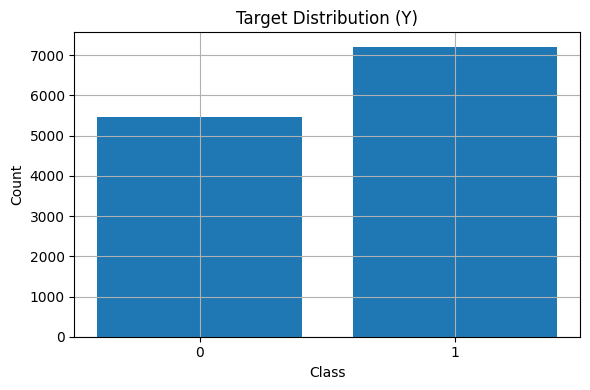

Positive rate: 0.5684326710816777


In [34]:
y_counts = df[TARGET].value_counts().sort_index()
print(y_counts)

plt.figure(figsize=(6,4))
plt.bar(y_counts.index.astype(str), y_counts.values)
plt.title("Target Distribution (Y)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

print("Positive rate:", (df[TARGET] == 1).mean())


The classes are relatively well-balanced, with a split of approximately 42% rejected vs. 58% accepted.

## Feature inspection

,Y
coupon,
Carry out & Take away,0.735478
Restaurant(<20),0.707107
Coffee House,0.499249
Restaurant(20-50),0.441019
Bar,0.410015


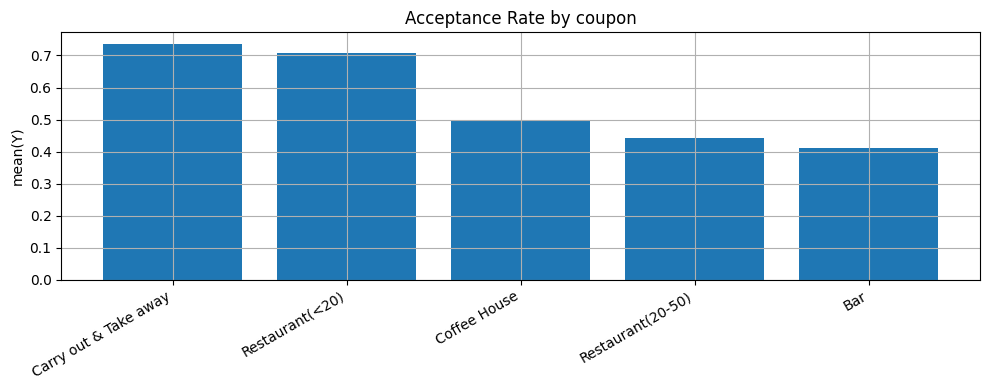

In [35]:
acc_by_coupon = df.groupby("coupon")[TARGET].mean().sort_values(ascending=False)
display(acc_by_coupon)

plt.figure(figsize=(10,4))
plt.bar(acc_by_coupon.index.astype(str), acc_by_coupon.values)
plt.title("Acceptance Rate by coupon")
plt.ylabel("mean(Y)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



The coupon type is a primary driver of behavior. High-frequency, low-cost options like Carry out ($73.5\%$) and Cheap Restaurants ($70.7\%$) show the strongest intent, while Bars and Expensive Restaurants are much harder to convert.

Numeric cols: ['temperature', 'has_children', 'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same', 'direction_opp']


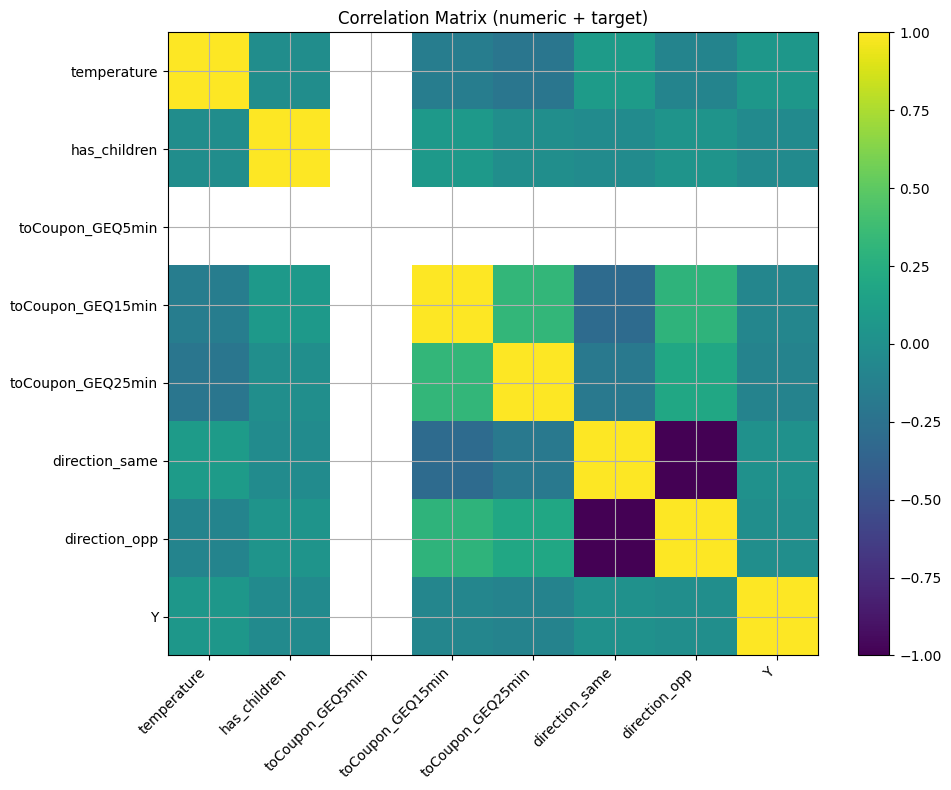

,Y
toCoupon_GEQ25min,-0.103633
toCoupon_GEQ15min,-0.081602
temperature,0.061240
has_children,-0.045557
direction_same,0.014570
direction_opp,-0.014570
toCoupon_GEQ5min,NaN


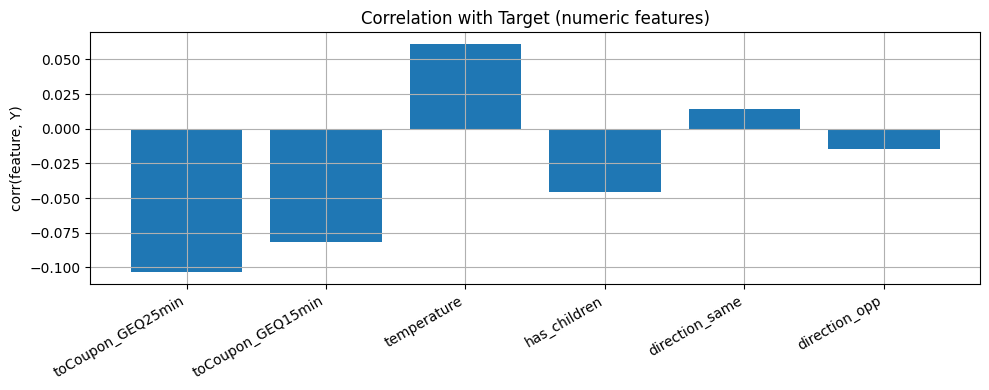

In [36]:
numeric_cols_all = df.select_dtypes(include=["int64","int32","float64","float32"]).columns.tolist()
numeric_cols_all = [c for c in numeric_cols_all if c != TARGET]

print("Numeric cols:", numeric_cols_all)

corr = df[numeric_cols_all + [TARGET]].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (numeric + target)")
plt.tight_layout()
plt.show()

# Target ile numeric korelasyonlarını sırala
corr_to_target = corr[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)
display(corr_to_target)

plt.figure(figsize=(10,4))
plt.bar(corr_to_target.index.astype(str), corr_to_target.values)
plt.title("Correlation with Target (numeric features)")
plt.ylabel("corr(feature, Y)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



The near-zero correlation for direction_same and direction_opp (0.01).

**Drop direction_opp:** This is perfectly redundant with direction_same. Keeping both creates multicollinearity, which can destabilize some models (like Logistic Regression).

toCoupon_GEQ features have nested correlation. We can create 1 feature for all.

Shown categorical columns: ['destination', 'passenger', 'weather', 'time', 'coupon', 'expiration']


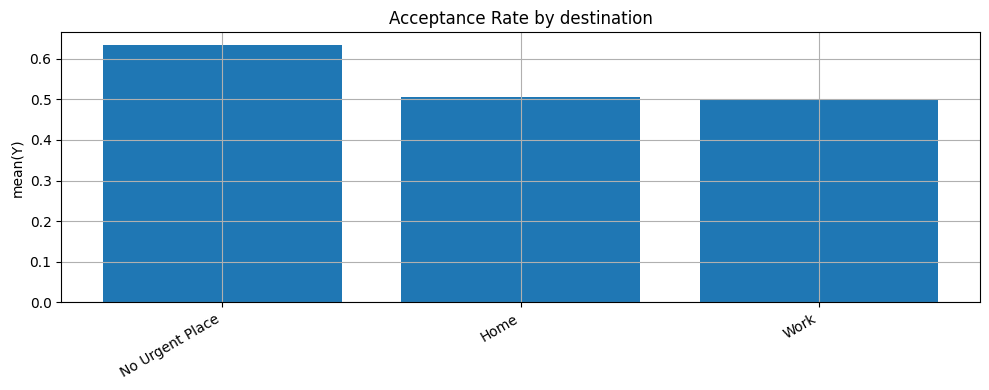

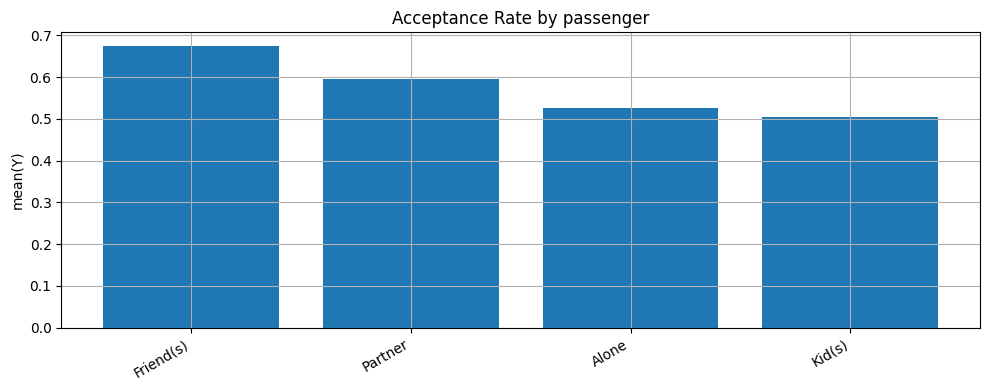

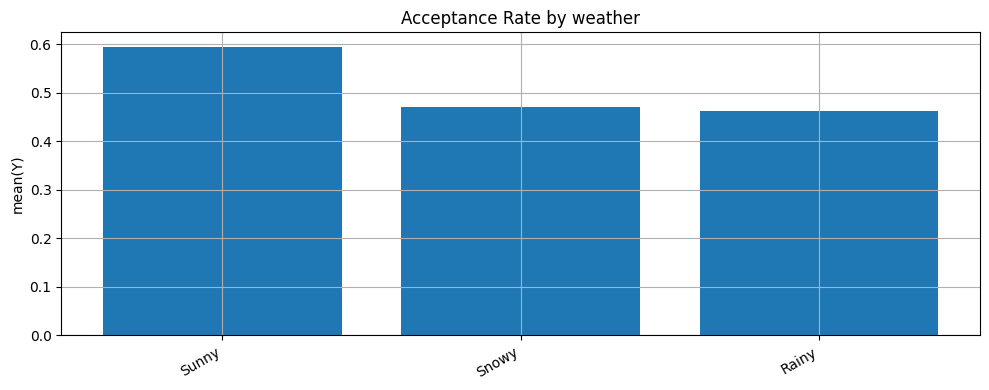

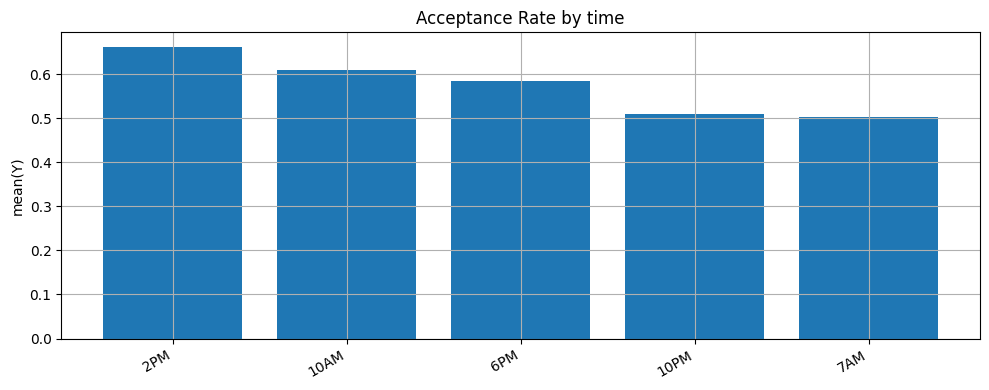

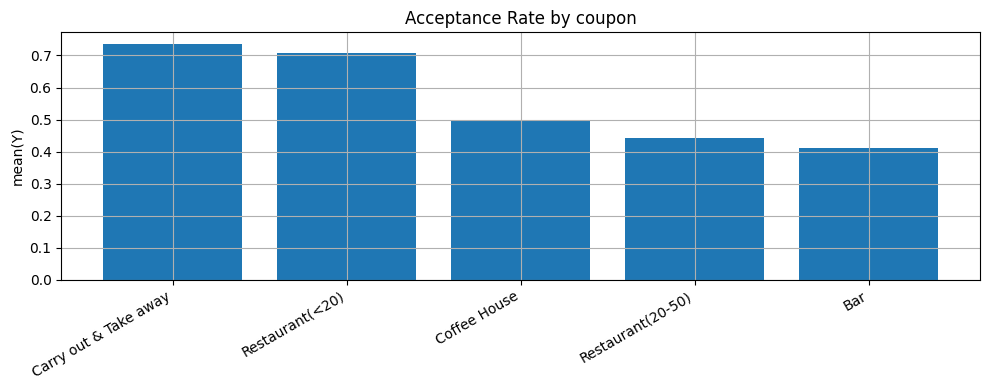

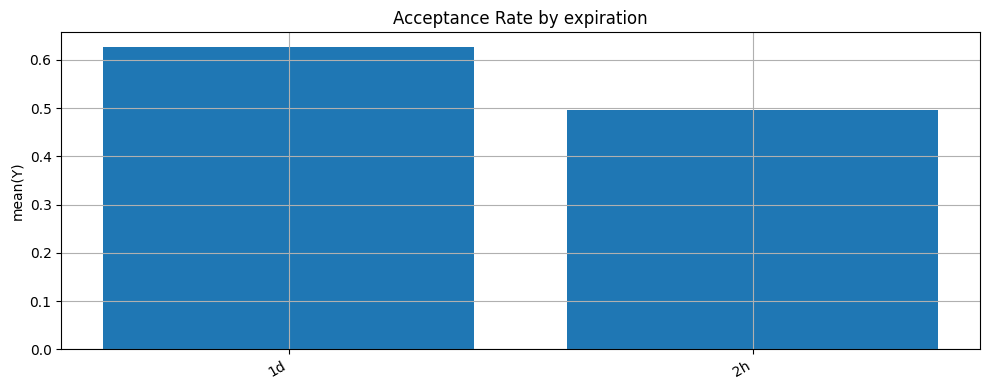

In [37]:
candidate_cat = [c for c in df.columns if c not in numeric_cols_all + [TARGET]]

show_cols = []
for c in candidate_cat:
    nunique = df[c].nunique(dropna=True)
    if 2 <= nunique <= 15:
        show_cols.append(c)
    if len(show_cols) >= 6:
        break

print("Shown categorical columns:", show_cols)

for c in show_cols:
    rates = df.groupby(c)[TARGET].mean().sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(f"Acceptance Rate by {c}")
    plt.ylabel("mean(Y)")
    plt.xticks(rotation=30, ha="right")
    plt.tight_layout()
    plt.show()


**Destination:** The "No Urgent Place" category has the highest acceptance rate. When users are heading to "Work" or "Home," they are likely focused on the commute and less willing to detour, resulting in lower acceptance.

**Social Factors:** Driving Alone results in the lowest acceptance rate. Having company—specifically Friends or a Partner—increases the likelihood of acceptance. This suggests that using these coupons is often a social activity (e.g., grabbing lunch with a friend).

**Weather & Temperature:** There is a clear preference for nice weather. Acceptance is highest when it is Sunny and warm (80°F). Bad weather (Rain/Snow) or cold temperatures (30°F) suppress the urge to go out and use a coupon.

**The "Cheap & Easy" Winner:** The highest acceptance rates are for "Restaurant (<$20)" and "Carry out & Take away". These are low-risk, low-cost, and high-convenience options.

**The "Luxury" Loser:** "Bar" coupons and expensive restaurants "Restaurant ($20-$50)" have much lower acceptance rates. These require a bigger commitment of time and money.

**Expiration:** Users prefer flexibility. Coupons valid for 1 Day are accepted significantly more often than those expiring in 2 Hours. The 2-hour window creates too much friction/urgency.

In [39]:
df.head()

,destination,passenger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0


# Preprocessing

## Remove Unnecessary Features

In [40]:
df = df.drop(columns=["car"])
df = df.drop(columns=["direction_opp"])

## Outlier Management

In [41]:
occupation_mapping = {
    'Computer & Mathematical': 'Technical engineering',
    'Architecture & Engineering': 'Technical engineering',
    'Life Physical Social Science': 'Technical engineering',
    'Sales & Related': 'Business Management',
    'Management': 'Business Management',
    'Office & Administrative Support': 'Business Management',
    'Business & Financial': 'Business Management',
    'Food Preparation & Serving Related': 'Social service',
    'Healthcare Support': 'Social service',
    'Transportation & Material Moving': 'Social service',
    'Building & Grounds Cleaning & Maintenance': 'Social service',
    'Education&Training&Library': 'Public affairs',
    'Healthcare Practitioners & Technical': 'Public affairs',
    'Community & Social Services': 'Public affairs',
    'Legal': 'Public affairs',
    'Protective Service': 'Public affairs',
    'Arts Design Entertainment Sports & Media': 'Creative industries',
    'Personal Care & Service': 'Creative industries',
    'Construction & Extraction': 'Basic industries',
    'Installation Maintenance & Repair': 'Basic industries',
    'Production Occupations': 'Basic industries',
    'Farming Fishing & Forestry': 'Basic industries',
    'Unemployed': 'Inactive employment',
    'Student': 'Inactive employment',
    'Retired': 'Inactive employment'
}

df['occupation'] = df['occupation'].replace(occupation_mapping)

df["occupation"].value_counts()

,count
occupation,
Inactive employment,3949
Business Management,3114
Public affairs,1822
Technical engineering,1753
Creative industries,804
Social service,802
Basic industries,440


## Feature Engineering

In [42]:
def get_distance_category(row):
    if row['toCoupon_GEQ25min'] == 1:
        return 2  # > 25 dakika
    elif row['toCoupon_GEQ15min'] == 1:
        return 1  # 15-25 dakika
    else:
        return 0  # 5-15 dakika

df['distance_category'] = df.apply(get_distance_category, axis=1)

df = df.drop(columns=['toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min'])

## Ordinal Encoding

In [43]:
expiration_map = {'2h': 0, '1d': 1}
df['expiration'] = df['expiration'].map(expiration_map)

Numeric cols: ['temperature', 'expiration', 'has_children', 'direction_same', 'distance_category']


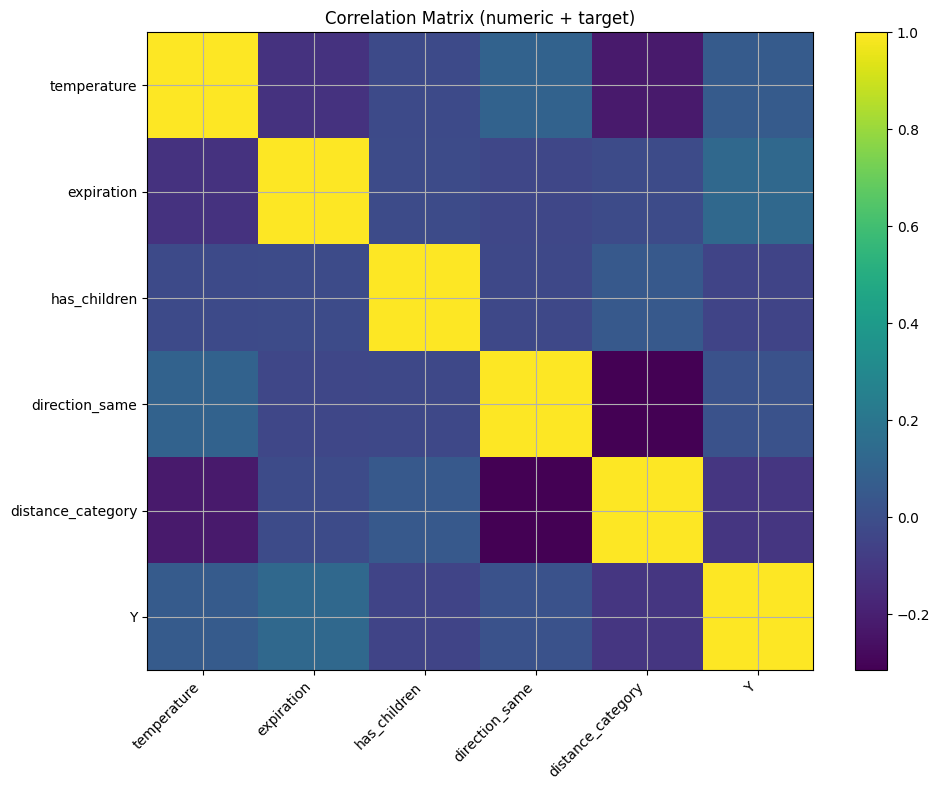

,Y
expiration,0.129920
distance_category,-0.109721
temperature,0.061240
has_children,-0.045557
direction_same,0.014570


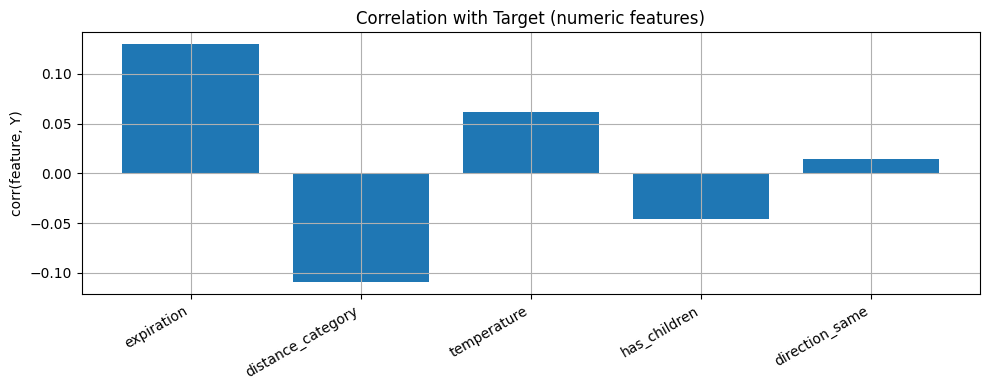

In [46]:
numeric_cols_all = df.select_dtypes(include=["int64","int32","float64","float32"]).columns.tolist()
numeric_cols_all = [c for c in numeric_cols_all if c != TARGET]

print("Numeric cols:", numeric_cols_all)


corr = df[numeric_cols_all + [TARGET]].corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (numeric + target)")
plt.tight_layout()
plt.show()

# Target ile numeric korelasyonlarını sırala
corr_to_target = corr[TARGET].drop(TARGET).sort_values(key=np.abs, ascending=False)
display(corr_to_target)

plt.figure(figsize=(10,4))
plt.bar(corr_to_target.index.astype(str), corr_to_target.values)
plt.title("Correlation with Target (numeric features)")
plt.ylabel("corr(feature, Y)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()



# Modelling

## Train/Test split

In [45]:
X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].astype(int).copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

numeric_cols = X_train.select_dtypes(include=["int64","int32","float64","float32"]).columns.tolist()
categorical_cols = [c for c in X_train.columns if c not in numeric_cols]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols))


Train shape: (10147, 21) Test shape: (2537, 21)
Numeric: 5 Categorical: 16


## Imputing and Scaling

In [47]:
numeric_preprocess = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocess_sparse = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

# Models like LR & SVC work well with sparse.
preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess_sparse, categorical_cols)
    ],
    remainder="drop"
)

# RandomForest generally wants/prefers dense -> dense onehot
categorical_preprocess_dense = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, numeric_cols),
        ("cat", categorical_preprocess_dense, categorical_cols)
    ],
    remainder="drop"
)


In [48]:
def eval_on_test(model, X_te, y_te, title):
    y_pred = model.predict(X_te)

    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_te)[:, 1]
    else:
        y_score = model.decision_function(X_te)

    f1 = f1_score(y_te, y_pred)
    roc = roc_auc_score(y_te, y_score)
    pr  = average_precision_score(y_te, y_score)

    print("\n" + "="*80)
    print(title)
    print(f"F1={f1:.4f} | ROC-AUC={roc:.4f} | PR-AUC={pr:.4f}")
    print(classification_report(y_te, y_pred, digits=4, zero_division=0))

    ConfusionMatrixDisplay.from_predictions(y_te, y_pred)
    plt.title(f"{title} - Confusion Matrix")
    plt.tight_layout()
    plt.show()

    RocCurveDisplay.from_predictions(y_te, y_score)
    plt.title(f"{title} - ROC Curve")
    plt.tight_layout()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y_te, y_score)
    plt.title(f"{title} - PR Curve")
    plt.tight_layout()
    plt.show()

    return {"model": title, "f1": f1, "roc_auc": roc, "pr_auc": pr}


Processing: DummyClassifier (most_frequent)...

DummyClassifier (most_frequent)
F1=0.7248 | ROC-AUC=0.5000 | PR-AUC=0.5684
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      1095
           1     0.5684    1.0000    0.7248      1442

    accuracy                         0.5684      2537
   macro avg     0.2842    0.5000    0.3624      2537
weighted avg     0.3231    0.5684    0.4120      2537



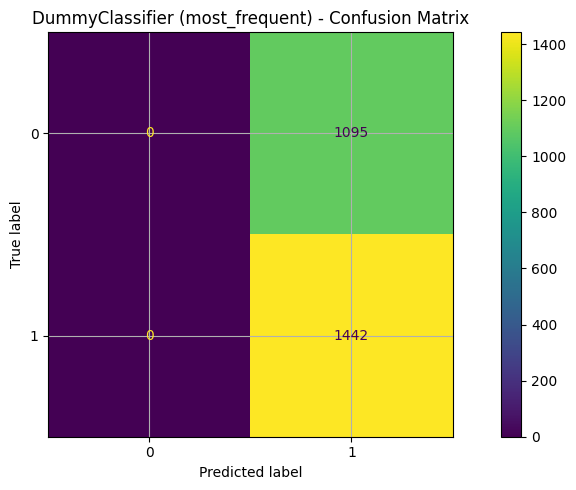

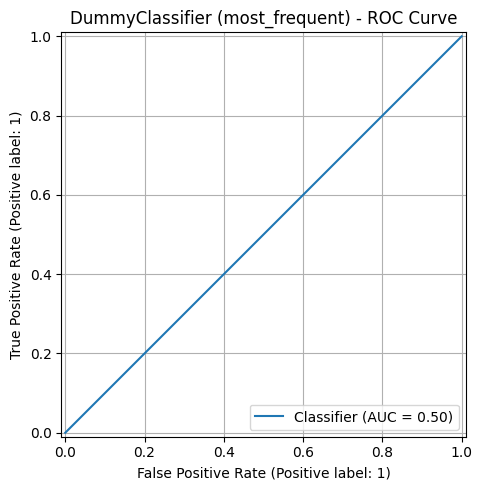

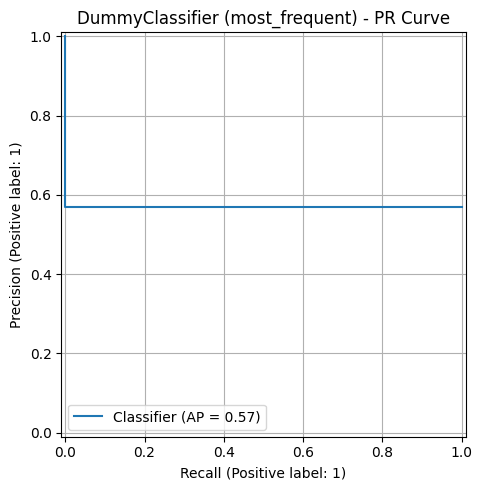

--- DummyClassifier (most_frequent) Result ---


,model,f1,roc_auc,pr_auc
0,DummyClassifier (most_frequent),0.724805,0.5,0.568388


In [52]:
name_dummy = "DummyClassifier (most_frequent)"
print(f"\nProcessing: {name_dummy}...")

dummy = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)

dummy.fit(X_train, y_train)
result_dummy = eval_on_test(dummy, X_test, y_test, name_dummy)


print(f"--- {name_dummy} Result ---")
display(pd.DataFrame([result_dummy]))

In [50]:
logistic_regression_model = LogisticRegression(random_state=RANDOM_STATE, max_iter=3000)
lr = Pipeline(steps=[
    ("preprocess", preprocess_sparse),
    ("model", logistic_regression_model)
])

print("Logistic Regression pipeline 'lr' created.")

Logistic Regression pipeline 'lr' created.



Processing: LogisticRegression (base)...

LogisticRegression (base)
F1=0.7350 | ROC-AUC=0.7337 | PR-AUC=0.7639
              precision    recall  f1-score   support

           0     0.6542    0.5598    0.6033      1095
           1     0.6987    0.7753    0.7350      1442

    accuracy                         0.6823      2537
   macro avg     0.6765    0.6676    0.6692      2537
weighted avg     0.6795    0.6823    0.6782      2537



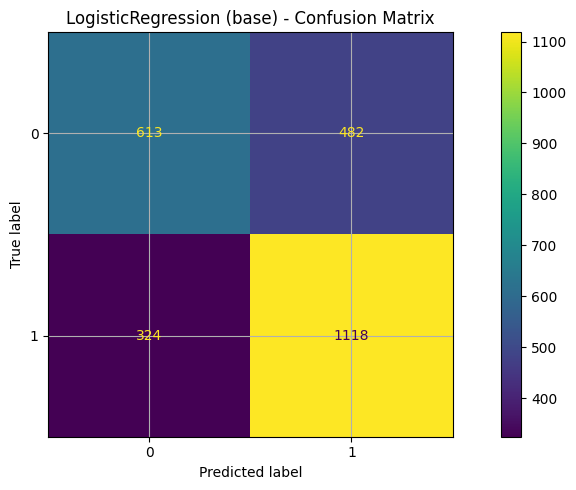

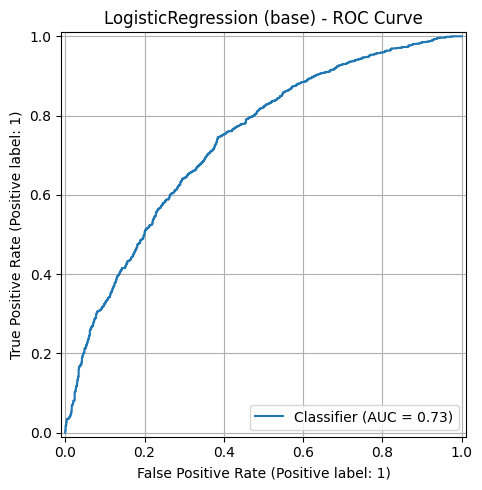

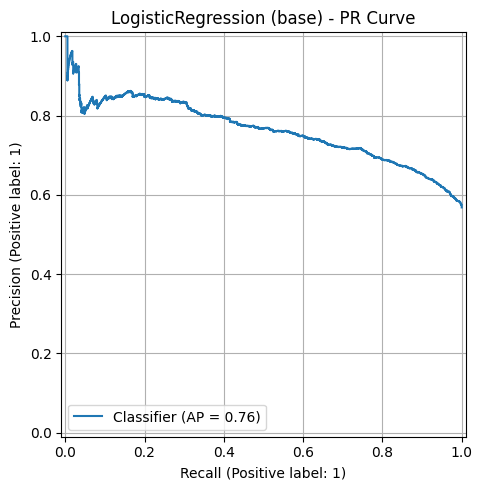

--- LogisticRegression (base) Result ---


,model,f1,roc_auc,pr_auc
0,LogisticRegression (base),0.735043,0.733727,0.763855


In [53]:
name_lr = "LogisticRegression (base)"
print(f"\nProcessing: {name_lr}...")

lr.fit(X_train, y_train)
result_lr = eval_on_test(lr, X_test, y_test, name_lr)

print(f"--- {name_lr} Result ---")
display(pd.DataFrame([result_lr]))

In [54]:
linear_svc_model = LinearSVC(random_state=RANDOM_STATE, dual=False, max_iter=3000)
svc = Pipeline(steps=[
    ("preprocess", preprocess_sparse),
    ("model", CalibratedClassifierCV(estimator=linear_svc_model, cv=3))
])

print("LinearSVC pipeline 'svc' created.")

LinearSVC pipeline 'svc' created.



Processing: LinearSVC + CalibratedClassifierCV (base)...

LinearSVC + CalibratedClassifierCV (base)
F1=0.7356 | ROC-AUC=0.7347 | PR-AUC=0.7644
              precision    recall  f1-score   support

           0     0.6557    0.5479    0.5970      1095
           1     0.6948    0.7816    0.7356      1442

    accuracy                         0.6807      2537
   macro avg     0.6753    0.6647    0.6663      2537
weighted avg     0.6780    0.6807    0.6758      2537



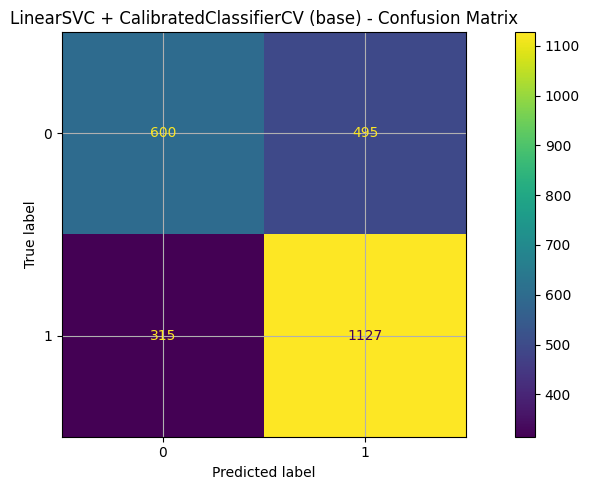

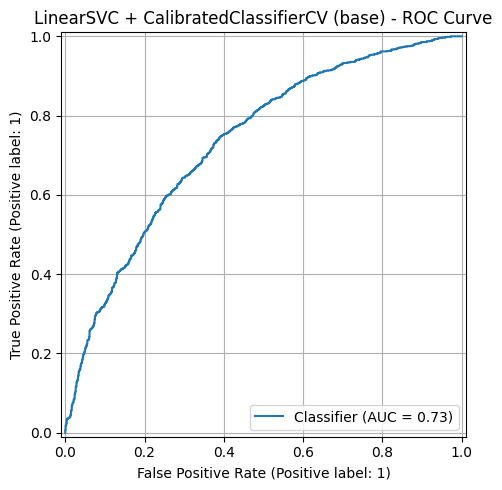

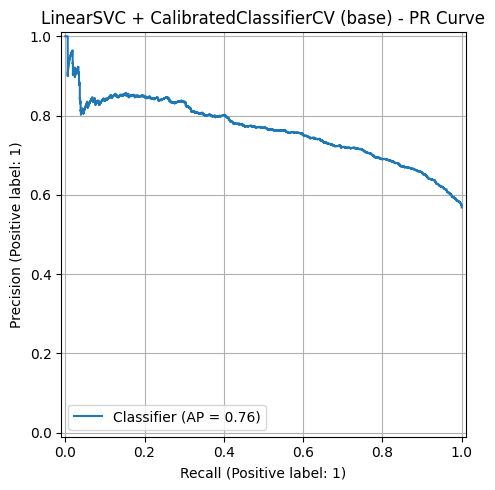

--- LinearSVC + CalibratedClassifierCV (base) Result ---


,model,f1,roc_auc,pr_auc
0,LinearSVC + CalibratedClassifierCV (base),0.73564,0.73471,0.764365


In [55]:
name_svc = "LinearSVC + CalibratedClassifierCV (base)"
print(f"\nProcessing: {name_svc}...")

svc.fit(X_train, y_train)
result_svc = eval_on_test(svc, X_test, y_test, name_svc)

print(f"--- {name_svc} Result ---")
display(pd.DataFrame([result_svc]))

**Reasoning**:
The next step is to define the RandomForest classifier pipeline, using the `preprocess_dense` ColumnTransformer as RandomForest models typically perform better with dense input.



In [56]:
random_forest_model = RandomForestClassifier(random_state=RANDOM_STATE)
rf = Pipeline(steps=[
    ("preprocess", preprocess_dense),
    ("model", random_forest_model)
])

print("RandomForest pipeline 'rf' created.")

RandomForest pipeline 'rf' created.



Preprocessing: RandomForest (base)...

RandomForest (base)
F1=0.7968 | ROC-AUC=0.8224 | PR-AUC=0.8413
              precision    recall  f1-score   support

           0     0.7497    0.6621    0.7032      1095
           1     0.7643    0.8322    0.7968      1442

    accuracy                         0.7588      2537
   macro avg     0.7570    0.7471    0.7500      2537
weighted avg     0.7580    0.7588    0.7564      2537



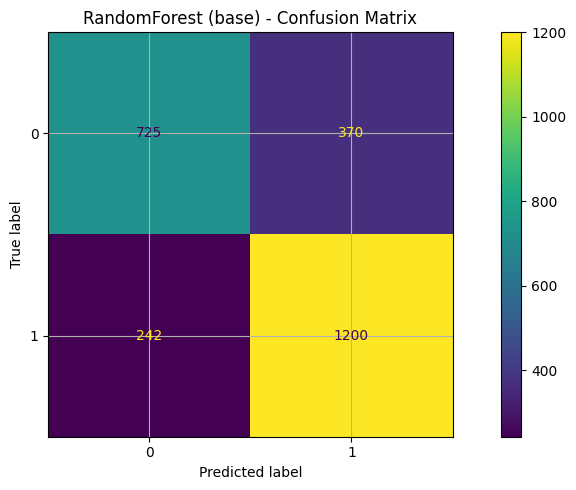

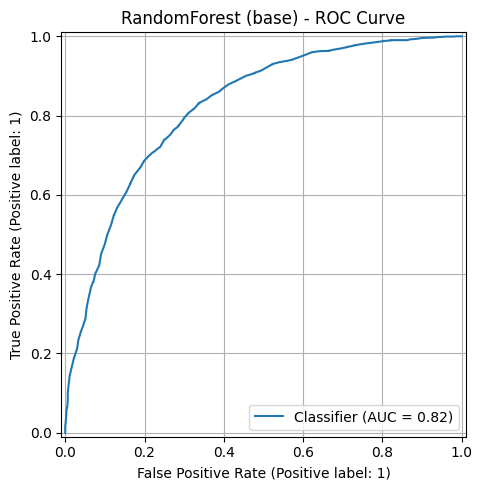

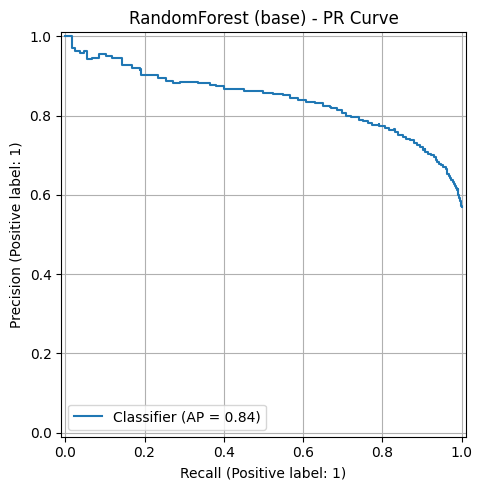

--- RandomForest (base) Result ---


,model,f1,roc_auc,pr_auc
0,RandomForest (base),0.796813,0.822385,0.841301


In [57]:
name_rf = "RandomForest (base)"
print(f"\nPreprocessing: {name_rf}...")

rf.fit(X_train, y_train)
result_rf = eval_on_test(rf, X_test, y_test, name_rf)

print(f"--- {name_rf} Result ---")
display(pd.DataFrame([result_rf]))

**Reasoning**:
Now that all three base models (Logistic Regression, LinearSVC, and RandomForest) have their pipelines defined, the next step is to fit these models on the training data and evaluate their performance on the test set using the `eval_on_test` function. This will generate the base performance metrics for comparison.



The results shown here are for illustrative purposes only.

CrossValidation was used to select the best model.




## Comparison of Models

In [59]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_validate

models = {
    "DummyClassifier": dummy,
    "LogisticRegression": lr,
    "LinearSVC+Calibrated": svc,
    "RandomForest": rf
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rows = []
for name, model in models.items():
    scores = cross_validate(
        model,
        X_train, y_train,
        cv=skf,
        scoring={"f1": "f1", "roc_auc": "roc_auc", "pr_auc": "average_precision"},
        n_jobs=-1,
        error_score=np.nan
    )
    rows.append({
        "model": name,
        "F1": scores["test_f1"].mean(),
        "ROC_AUC": scores["test_roc_auc"].mean(),
        "PR_AUC": scores["test_pr_auc"].mean()
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC", ascending=False).reset_index(drop=True)
display(results)
print("Best (ROC_AUC):", results.loc[0, "model"])


,model,F1,ROC_AUC,PR_AUC
0,RandomForest,0.795958,0.827620,0.848038
1,LinearSVC+Calibrated,0.734431,0.735511,0.775022
2,LogisticRegression,0.733195,0.735236,0.775054
3,DummyClassifier,0.724851,0.500000,0.568444


Best (ROC_AUC): RandomForest


# Random Search + Grid Search for best result

In [60]:
import numpy as np
from scipy.stats import randint
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1) RANDOM SEARCH
param_dist = {
    "model__n_estimators": randint(100, 600),
    "model__max_depth": [None, 10, 20, 30, 40, 50],
    "model__min_samples_split": randint(2, 11),
    "model__min_samples_leaf": randint(1, 5),
    "model__max_features": ["sqrt"]
}

rs = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,
    verbose=1,
    random_state=RANDOM_STATE,
    refit=False
)

rs.fit(X_train, y_train)
print("Random Search best score:", rs.best_score_)
print("Random Search best params:", rs.best_params_)


Fitting 5 folds for each of 15 candidates, totalling 75 fits
Random Search best score: 0.8334864967874868
Random Search best params: {'model__max_depth': 50, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 443}


In [61]:
# 2) GRID SEARCH
best = rs.best_params_
best_n = best["model__n_estimators"]
best_d = best["model__max_depth"]
best_split = best["model__min_samples_split"]
best_leaf  = best["model__min_samples_leaf"]

grid_n = sorted(set([max(100, best_n - 50), best_n, best_n + 50]))
grid_split = sorted(set([max(2, best_split - 1), best_split, best_split + 1]))
grid_leaf  = sorted(set([max(1, best_leaf - 1), best_leaf, best_leaf + 1]))

if best_d is None:
    grid_depth = [None, 30]
else:
    grid_depth = sorted(set([max(5, best_d - 5), best_d, best_d + 5]))

fine_grid = {
    "model__n_estimators": grid_n,
    "model__max_depth": grid_depth,
    "model__min_samples_split": grid_split,
    "model__min_samples_leaf": grid_leaf,
    "model__max_features": ["sqrt"]
}

print("Grid:", fine_grid)

gs = GridSearchCV(
    estimator=rf,
    param_grid=fine_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,
    verbose=1,
    refit=True
)

gs.fit(X_train, y_train)

print("Grid Search best score:", gs.best_score_)
print("Grid Search best params:", gs.best_params_)

best_model = gs.best_estimator_

Grid: {'model__n_estimators': [393, 443, 493], 'model__max_depth': [45, 50, 55], 'model__min_samples_split': [2, 3, 4], 'model__min_samples_leaf': [1, 2], 'model__max_features': ['sqrt']}
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Grid Search best score: 0.833573063970704
Grid Search best params: {'model__max_depth': 45, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 3, 'model__n_estimators': 493}


## Comparison of Tuned Model

In [62]:
import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold, cross_validate

cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

rf_base = rf
rf_tuned = clone(rf).set_params(**gs.best_params_)

models_2 = {
    "RF (base)": rf_base,
    "RF (tuned)": rf_tuned
}

rows = []
for name, model in models_2.items():
    out = cross_validate(
        model, X_train, y_train,
        cv=cv2,
        scoring={"f1": "f1", "roc_auc": "roc_auc", "pr_auc": "average_precision"},
        n_jobs=-1,
        error_score=np.nan
    )
    rows.append({
        "model": name,
        "F1_mean": out["test_f1"].mean(),
        "ROC_AUC_mean": out["test_roc_auc"].mean(),
        "PR_AUC_mean": out["test_pr_auc"].mean()
    })

results = pd.DataFrame(rows).sort_values("ROC_AUC_mean", ascending=False).reset_index(drop=True)
display(results)
print("Best (ROC_AUC_mean):", results.loc[0, "model"])


,model,F1_mean,ROC_AUC_mean,PR_AUC_mean
0,RF (tuned),0.802815,0.833573,0.857239
1,RF (base),0.795958,0.827620,0.848038


Best (ROC_AUC_mean): RF (tuned)


## Important Feauters

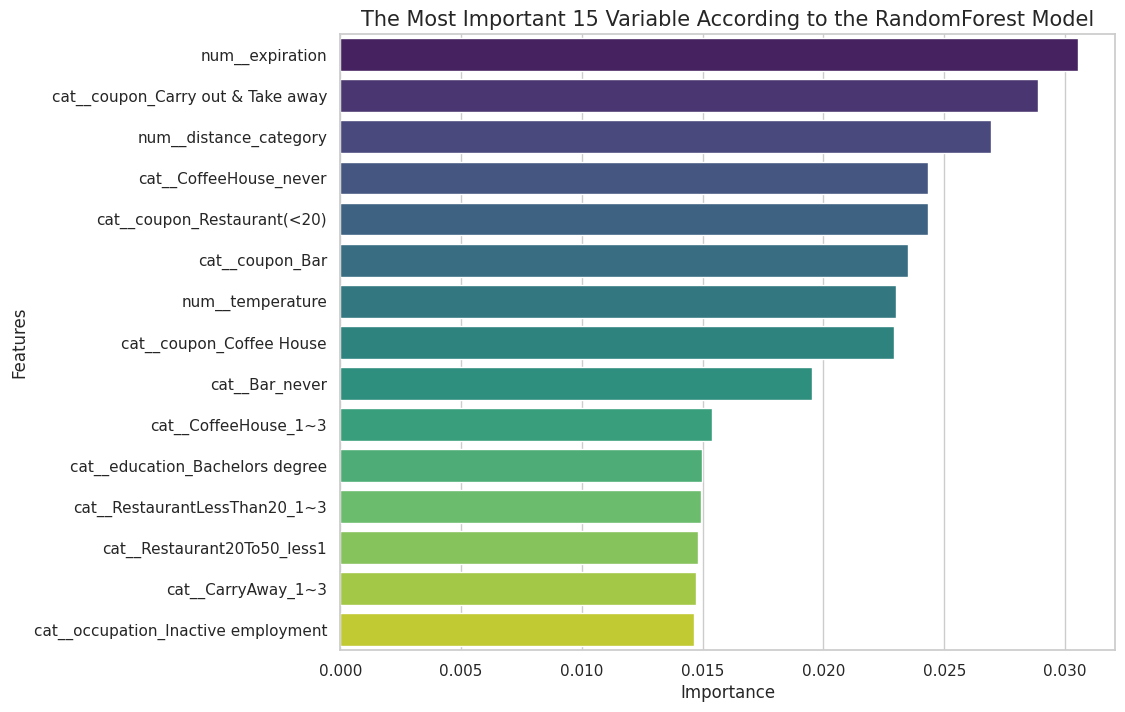

The most Important 15 feature:


,Feature,Importance
1,num__expiration,0.030549
21,cat__coupon_Carry out & Take away,0.028870
4,num__distance_category,0.026935
71,cat__CoffeeHouse_never,0.024328
24,cat__coupon_Restaurant(<20),0.024307
20,cat__coupon_Bar,0.023499
0,num__temperature,0.022982
22,cat__coupon_Coffee House,0.022922
66,cat__Bar_never,0.019522
67,cat__CoffeeHouse_1~3,0.015384


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# The final step (model) and the previous steps (preprocessor) of the pipeline are separated.
model_step = best_model.steps[-1][1]  # RandomForest
preprocessor_step = best_model.steps[0][1] # Transformer/Preprocessor

# 1. Get Feature Importance values
importances = model_step.feature_importances_

# 2. Correctly Extracting Feature Names from the Pipeline
try:
    # We want the "transformed" names from the part of the pipeline before the model.
    feature_names = best_model[:-1].get_feature_names_out()
except AttributeError:
    feature_names = [f"Feature_{i}" for i in range(len(importances))]

# 3. DataFrame creation
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Visualization
plt.figure(figsize=(10, 8))
sns.set_theme(style="whitegrid")

# Show top 15 feature
top_n = 15
sns.barplot(x='Importance', y='Feature', hue='Feature', legend=False, data=feature_imp_df.head(top_n), palette='viridis')
plt.title(f'The Most Important {top_n} Variable According to the RandomForest Model', fontsize=15)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.show()

print("The most Important 15 feature:")
display(feature_imp_df.head(15))

## Threshold Selection and Final Result

OOF-CV threshold: 0.4789 | OOF F1: 0.8074

=== FINAL TEST ===
Threshold=0.4789 | F1=0.8014 | ROC-AUC=0.8285 | PR-AUC=0.8486
              precision    recall  f1-score   support

           0     0.7741    0.6164    0.6863      1095
           1     0.7477    0.8634    0.8014      1442

    accuracy                         0.7568      2537
   macro avg     0.7609    0.7399    0.7439      2537
weighted avg     0.7591    0.7568    0.7517      2537



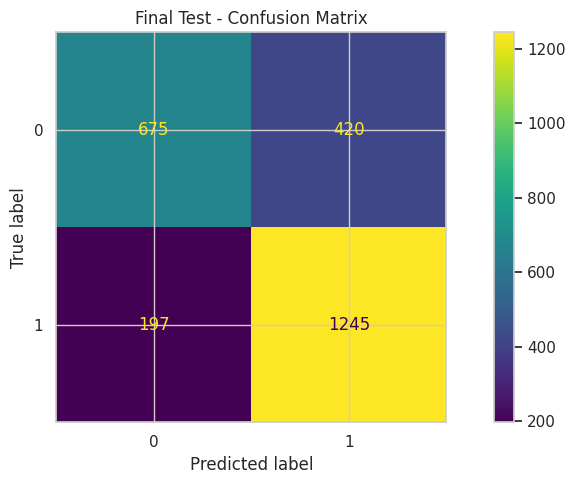

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score, roc_auc_score, average_precision_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

oof = cross_val_predict(
    best_model, X_train, y_train,
    cv=skf, method="predict_proba", n_jobs=-1
)[:, 1]

p, r, thr = precision_recall_curve(y_train, oof)
f1s = 2 * p[:-1] * r[:-1] / (p[:-1] + r[:-1] + 1e-12)

best_i = np.argmax(f1s)
best_thr = thr[best_i]

print(f"OOF-CV threshold: {best_thr:.4f} | OOF F1: {f1s[best_i]:.4f}")

best_model.fit(X_train, y_train)

test_score = best_model.predict_proba(X_test)[:, 1]
y_pred = (test_score >= best_thr).astype(int)

print("\n=== FINAL TEST ===")
print(f"Threshold={best_thr:.4f} | F1={f1_score(y_test, y_pred):.4f} | "
      f"ROC-AUC={roc_auc_score(y_test, test_score):.4f} | "
      f"PR-AUC={average_precision_score(y_test, test_score):.4f}")

print(classification_report(y_test, y_pred, digits=4, zero_division=0))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Final Test - Confusion Matrix")
plt.tight_layout()
plt.show()
